# Correlatie tussen IMDB Score, Facebook likes en Revenue van een film

Door: Atilla Bosma, Ronald de Rooij en Robin Tempert

Datasets:
- 2 datasets met IMDB Scores en Revenue

Wij hebben 1 dataset met de facebook likes, en 1 dataset die deze niet heeft. De 2de dataset zonder facebook likes wordt gebruikt om missende data in het eerste dataset aan te vullen met IMDB scores en gross revenue.

De hoofdvraag die we willen gaan beantwoorden is:

Hoe beïnvloedt het aantal facebook likes van schrijvers en acteurs de IMDB score en opbrengst van uitgebrachte films?

Dit gaan we onderzoeken door de volgende deelvragen te beantwoorden:


1. Kunnen wij met supervised machine learning voorspellen wat de IMDB score van een film is gebaseerd op de facebook likes?
2. Kunnen wij met unsupervised machine learning voorspellen hoeveel een film verdient gebaseerd op zijn IMDB Score?
3.  Is het mogelijk om onze dataset te verbinden met een groter IMDB dataset en deze gemergede dataset te gebruiken?
4. Is er een correlatie tussen facebook likes en IMDB score, en IMDB score en inkomst?

Als eerst willen wij kijken of wij complete data hebben en of wij deze data kunnen opschonen en mergen met het 2de dataset, dit kunt u in de volgende stappen zien:

In [2]:
# Bibliotheken
from datetime import datetime
import pandas as pd
import numpy as np
import scipy as sp
import bokeh
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix
import seaborn as sns

from bokeh.plotting import *
from bokeh.layouts import row, widgetbox
from bokeh.models import CustomJS, Slider

bokeh.plotting.output_notebook()

%matplotlib inline

Loading BokehJS ...

In [3]:
movieData = pd.read_csv('movie_metadata.csv', sep=',')
movieData["total_likes"] = movieData["movie_facebook_likes"] + movieData["actor_1_facebook_likes"] + movieData["actor_2_facebook_likes"]+ movieData["actor_3_facebook_likes"]
movieData.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,total_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,35791.0
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,46000.0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000,96554.0
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000,237000.0
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0,NaN


In [9]:
imdbExtraData = pd.read_csv('IMDB-Movie-Data.csv', sep=',')
imdbExtraData.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


## Data Analyze

Wij willen eerst kijken wat voor data wij allemaal hebben en hoe compleet deze data is:

In [10]:
print(movieData.columns)

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes', 'total_likes'],
      dtype='object')


In [11]:
print(imdbExtraData.columns)

Index(['Rank', 'Title', 'Genre', 'Description', 'Director', 'Actors', 'Year',
       'Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)',
       'Metascore'],
      dtype='object')


Graag willen wij ook even weten wat voor typen data wij hebben:

In [12]:
movieArray = movieData.infer_objects()

movieArray.dtypes

color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
m

In [13]:
imdbArray = imdbExtraData.infer_objects()

imdbArray.dtypes

Rank                    int64
Title                  object
Genre                  object
Description            object
Director               object
Actors                 object
Year                    int64
Runtime (Minutes)       int64
Rating                float64
Votes                   int64
Revenue (Millions)    float64
Metascore             float64
dtype: object

Wat er dan nog verkeerd aan onze Numpy Arrays is, is dat de String Lists (Bijvoorbeeld Genre's of Acteurs) geen lists zijn. 

Voordat wij dit kunnen fixen moeten wij eerst rows droppen die NaN zijn. 

Eerst willen wij weten hoeveel NaN values wij nou echt hebben.

In [14]:
print(pd.isnull(movieArray).sum())

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
total_likes                   23
dtype: int64


In [15]:
print(pd.isnull(imdbArray).sum())

Rank                    0
Title                   0
Genre                   0
Description             0
Director                0
Actors                  0
Year                    0
Runtime (Minutes)       0
Rating                  0
Votes                   0
Revenue (Millions)    128
Metascore              64
dtype: int64


Wat we best snel kunnen zien is dat de Gross Revenue vaak NaN is, in onze eerste dataset hebben wij van 884 films hun revenue gewoon helemaal niet (Dat is al bijna 1/5de van onze volledige dataset).

Dit kan later voor problemen zorgen wanneer wij machine learning gebruiken om te voorspellen hoeveel revenue een film krijgt gebaseerd op facebook likes van de acteurs/cast/directeurs.

Laten wij eerst de data een beetje opschonen, ten eerste willen wij de Strings die eigenlijk lijsten van acteurs/genres/etc zijn omzetten naar echte lijsten. Ook willen wij rows weggooien die data hebben die wij moeten hebben, deze data is: Revenue (Millions), Metascore, imdb_score, director_name, director_facebook_likes, actor_1_name, actor_1_facebook_likes, actor_2_name, actor_2_facebook_likes, actor_3_name, actor_3_facebook_likes, budget en gross.

Dit doe ik hier:

In [16]:
imdbArray = imdbArray.dropna(subset=['Revenue (Millions)'])
imdbArray = imdbArray.dropna(subset=['Metascore'])

movieArray = movieArray.dropna(subset=['imdb_score'])
movieArray = movieArray.dropna(subset=['director_name'])
movieArray = movieArray.dropna(subset=['director_facebook_likes'])
movieArray = movieArray.dropna(subset=['actor_1_name'])
movieArray = movieArray.dropna(subset=['actor_1_facebook_likes'])
movieArray = movieArray.dropna(subset=['actor_2_name'])
movieArray = movieArray.dropna(subset=['actor_2_facebook_likes'])
movieArray = movieArray.dropna(subset=['actor_3_name'])
movieArray = movieArray.dropna(subset=['actor_3_facebook_likes'])
movieArray = movieArray.dropna(subset=['budget'])
movieArray = movieArray.dropna(subset=['gross'])

#Na het verwijderen van NaN values moet de index ook nog gereset worden van de Arrays, anders kan dat snel voor errors zorgen

movieArray.reset_index(drop=True, inplace=True)
imdbArray.reset_index(drop=True, inplace=True)

In [17]:
print(pd.isnull(movieArray).sum())

color                         2
director_name                 0
num_critic_for_reviews        1
duration                      1
director_facebook_likes       0
actor_3_facebook_likes        0
actor_2_name                  0
actor_1_facebook_likes        0
gross                         0
genres                        0
actor_1_name                  0
movie_title                   0
num_voted_users               0
cast_total_facebook_likes     0
actor_3_name                  0
facenumber_in_poster          6
plot_keywords                30
movie_imdb_link               0
num_user_for_reviews          0
language                      3
country                       0
content_rating               47
budget                        0
title_year                    0
actor_2_facebook_likes        0
imdb_score                    0
aspect_ratio                 73
movie_facebook_likes          0
total_likes                   0
dtype: int64


In [18]:
print(pd.isnull(imdbArray).sum())

Rank                  0
Title                 0
Genre                 0
Description           0
Director              0
Actors                0
Year                  0
Runtime (Minutes)     0
Rating                0
Votes                 0
Revenue (Millions)    0
Metascore             0
dtype: int64


Nu hebben wij dus geen rows meer met NaN data, dit kan wel zorgen voor minder correcte data. Maar sinds wij 2 zeer grote Datasets hebben zou dit geen probleem horen te zijn.

Nu er geen NaN data meer is kan ik met een lambda en de split functie alle columns die een String list in een String hebben omzetten naar lists.

In [19]:
movieArray['genres'] = movieArray['genres'].apply(lambda x : x.split('|'))

movieArray['genres'].head()

0    [Action, Adventure, Fantasy, Sci-Fi]
1            [Action, Adventure, Fantasy]
2           [Action, Adventure, Thriller]
3                      [Action, Thriller]
4             [Action, Adventure, Sci-Fi]
Name: genres, dtype: object

In [20]:
#Split geeft errors bij een NaN value
movieArray = movieArray.dropna(subset=['plot_keywords'])
movieArray['plot_keywords'] = movieArray['plot_keywords'].apply(lambda x : x.split('|'))
movieArray['plot_keywords'].head()

0         [avatar, future, marine, native, paraplegic]
1    [goddess, marriage ceremony, marriage proposal...
2            [bomb, espionage, sequel, spy, terrorist]
3    [deception, imprisonment, lawlessness, police ...
4    [alien, american civil war, male nipple, mars,...
Name: plot_keywords, dtype: object

In [21]:
imdbArray['Genre'] = imdbArray['Genre'].apply(lambda x : x.split(','))
imdbArray['Genre'].head()

0     [Action, Adventure, Sci-Fi]
1    [Adventure, Mystery, Sci-Fi]
2              [Horror, Thriller]
3     [Animation, Comedy, Family]
4    [Action, Adventure, Fantasy]
Name: Genre, dtype: object

Voor onze eerste dataset hebben wij ook de column Color niet nodig, wij gooien deze dus weg

In [22]:
movieArray = movieArray.drop(columns='color')
movieArray.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,total_likes
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,"[Action, Adventure, Fantasy, Sci-Fi]",CCH Pounder,...,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,35791.0
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,"[Action, Adventure, Fantasy]",Johnny Depp,...,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,46000.0
2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,"[Action, Adventure, Thriller]",Christoph Waltz,...,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000,96554.0
3,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,"[Action, Thriller]",Tom Hardy,...,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000,237000.0
4,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,"[Action, Adventure, Sci-Fi]",Daryl Sabara,...,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000,25802.0


Wat wij dus willen weten is de gross revenue gebaseerd op IMDB score en gebaseerd op Facebook likes. Wij mergen dus eerst onze datasets samen zodat wij een globale dataset hebben die wij hiervoor kunnen gebruiken:

In [23]:
arraysToKeepMovieArray = ['movie_title', 'imdb_score', 'gross', 'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes']

ndf = movieArray[arraysToKeepMovieArray]

#Het decimaalpunt stond verkeerd in deze
ndf['imdb_score'] = ndf.imdb_score.apply(lambda x: x * 10)

C:\Users\robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
arraysToKeepImdbArray = ['movie_title', 'imdb_score', 'gross']

imdbArray = imdbArray.rename(columns={'Title' : 'movie_title', 'Metascore' : 'imdb_score', 'Revenue (Millions)' : 'gross'})

ndf2 = imdbArray[arraysToKeepImdbArray]

imdbMergedArray = ndf.merge(ndf2, how='left')

imdbMergedArray = imdbMergedArray.reset_index()

imdbMergedArray = imdbMergedArray.set_index('index')

imdbMergedArray.head()

,movie_title,imdb_score,gross,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
index,,,,,,,
0,Avatar,79.0,760505847.0,0.0,1000.0,936.0,855.0
1,Pirates of the Caribbean: At World's End,71.0,309404152.0,563.0,40000.0,5000.0,1000.0
2,Spectre,68.0,200074175.0,0.0,11000.0,393.0,161.0
3,The Dark Knight Rises,85.0,448130642.0,22000.0,27000.0,23000.0,23000.0
4,John Carter,66.0,73058679.0,475.0,640.0,632.0,530.0


Wij hebben nu een gemergede Array die de movie_title, imdb_score, gross revenue en alle likes heeft. Dit maakt het zeer makkelijk om alles te plotten.

## Gemiddeldes

In [25]:
averageLikes = movieData["movie_facebook_likes"].mean()
print("Gemidelde aantal likes per film is " + str(averageLikes))

Gemidelde aantal likes per film is 7525.9645052548085


In [26]:
movieData["movie_facebook_likes"].std()

19320.445109946737

## Meeste likes 

In [27]:
def getTotalLikesByColumn(column):
    groupedFacebookLikes = movieData.groupby(column)["movie_facebook_likes"].sum()
    key = groupedFacebookLikes.idxmax()
    maxSum = groupedFacebookLikes.max()
    return str(key) + " heeft totaal "+ str(maxSum) + " likes";

In [28]:
print("De director met de meeste likes:")
print(getTotalLikesByColumn("director_name"))

De director met de meeste likes:
Christopher Nolan heeft totaal 829000 likes


In [29]:
print("De hoofd acteur met de meeste likes:")
print(getTotalLikesByColumn("actor_1_name"))

De hoofd acteur met de meeste likes:
Leonardo DiCaprio heeft totaal 1096000 likes


In [30]:
print("De film met de meeste likes:")
print(getTotalLikesByColumn("movie_title"))

De film met de meeste likes:
Interstellar  heeft totaal 349000 likes


## Minste likes

In [31]:
def getMinLikesByColumn(column):
    groupedFacebookLikes = movieData.groupby(column)["movie_facebook_likes"].sum()
    key = groupedFacebookLikes.idxmin()
    maxSum = groupedFacebookLikes.min()
    return str(key) + " heeft totaal "+ str(maxSum) + " likes";

In [32]:
print("De director met de minste likes:")
print(getMinLikesByColumn("director_name"))

De director met de minste likes:
Aaron Hann heeft totaal 0 likes


In [33]:
print("De hoofd acteur met de minste likes:")
print(getMinLikesByColumn("actor_1_name"))

De hoofd acteur met de minste likes:
50 Cent heeft totaal 0 likes


In [34]:
print("De film met de minste likes:")
print(getMinLikesByColumn("movie_title"))

De film met de minste likes:
10,000 B.C.              heeft totaal 0 likes


## Is er een correlatie tussen facebook likes en IMDB score, en IMDB score en inkomst?
Wij hebben een set met data die is opgeschoond en bruikbaar is voor onderzoek.

Met deze set willen wij kijken of er een relatie is tussen de facebook likes van de film en de score op IBMD.
Dit gaan wij doen door eerst de jaren van de films te onderzoeken.

In [35]:
#Haalt alle jaren op van de data
movieYears = movieData["title_year"]

In [36]:
#Het eerste jaar
movieYears.min()

1916.0

In [37]:
#Het laatste jaar
movieYears.max()

2016.0

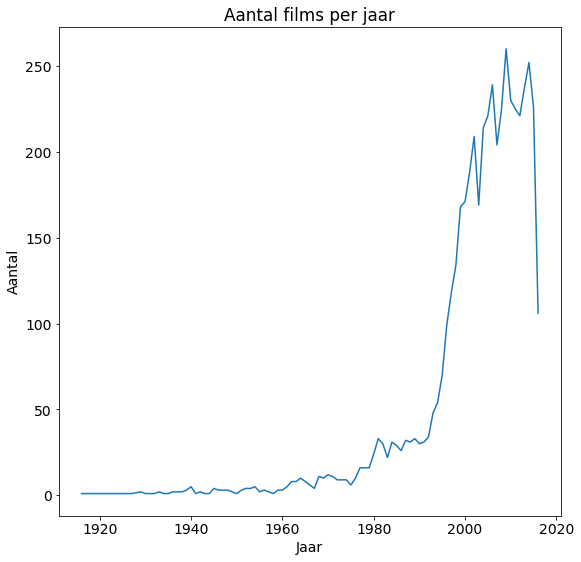

In [60]:
#haalt de aantal films per jaar op
movieYearLabels,movieYearCounts = np.unique(movieYears,return_counts=True)
y_pos = np.arange(len(movieYearLabels))

plt.plot(movieYearLabels, movieYearCounts)
plt.ylabel("Aantal")
plt.xlabel("Jaar")
plt.title("Aantal films per jaar")
plt.show()

In de deze graph kunnen wij zien, zoals verwacht, dat na 1980 er veel meer films uit kwamen. 
Dit heeft natuurlijk te maken met dat de techonologie beter is geworden waardoor er sneller en goedkoper films uit gebracht kunnen worden maar ook kunnen worden weergegeven.

Ook kunnen wij hierin zien dat in 2016, het laatste data point, er een daling is van de aantal gemaakte films.
De daling heeft geen directe colleratie in de data.

In [39]:
movieDurations = movieData.groupby("title_year")["duration"]
averageMovieTime = movieDurations.mean()

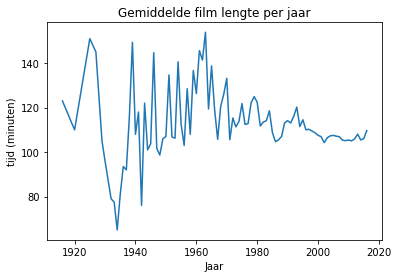

In [40]:
averageMovieTime.plot()
plt.ylabel("tijd (minuten)")
plt.xlabel("Jaar")
plt.title("Gemiddelde film lengte per jaar")
plt.show()

Ook zien we hier dat de films steeds meer de zelfde lengte krijgen.
Dit komt ook doordat er minder films waren in de eerdere jaren.
Hierdoor krijg je veel uitschieters en wordt hier mee het gemiddelde aangepast.

In [41]:
totalFacebookLikes = movieData.groupby("title_year")["movie_facebook_likes"].sum()

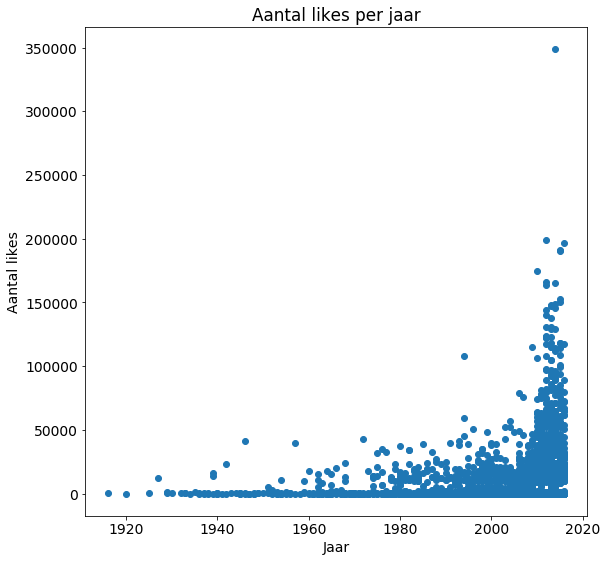

In [75]:
plt.scatter(movieData["title_year"], movieData["movie_facebook_likes"])
plt.ylabel("Aantal likes")
plt.xlabel("Jaar")
plt.title("Aantal likes per jaar")
plt.show()

Zoals we hier zien is dat films voor 2004 weinig likes hebben. 
Dit komt waarschijnlijk doordat Facebook is opgericht in 2004 en wanneer een film wordt aangekondigt of uitkomt wordt dit op Facebook besproken.

Ook zien we hier weer in het jaar 2016 dat er minder likes komt. Dit komt weer terug op wat er eerder verteld is.

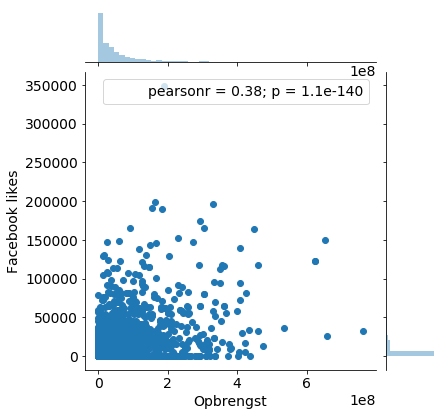

In [87]:
p = sns.jointplot(movieData["gross"], movieData["movie_facebook_likes"]).set_axis_labels("Opbrengst", "Facebook likes")

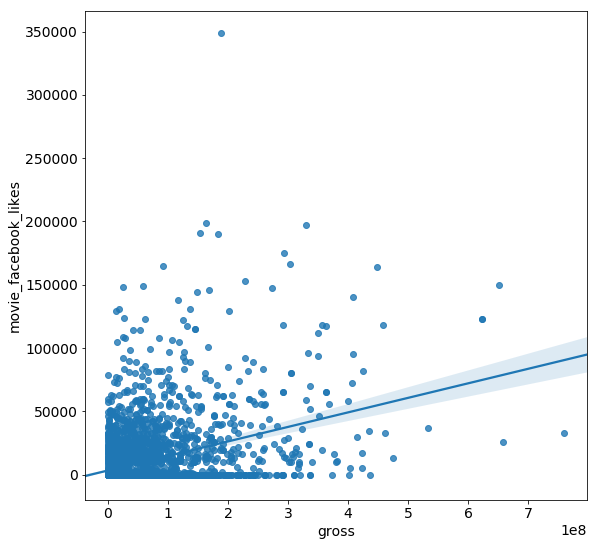

In [88]:
q= sns.regplot(x=movieData["gross"], y=movieData["movie_facebook_likes"])

In [45]:
#Uitschieter likes
maxLikes = movieData["movie_facebook_likes"].max()
maxLikes

349000

In [46]:
#Uitschieter opbrengst
maxLikes = movieData["gross"].max()
maxLikes

760505847.0

Zoals we in de scatter plot kunnen zien is dat het meeste onder de 100000 likes is.
En het meeste onder de 3*1e8=300000000 (300m) dollar ligt.

Ook zien we dat films met een hoge opbrengst niet persee meer likes heeft.

## Maken de acteurs de film meer populair/goed
Meestal zal je bedenken dat wanneer je een bekende acteur(s) inzet in een film deze film ook bekender is en een betere IMDB score krijgt.
Maar is dit ook zo?

Eerst kijken we of de Facebook likes ook een corelatie heeft met de IMDB score.

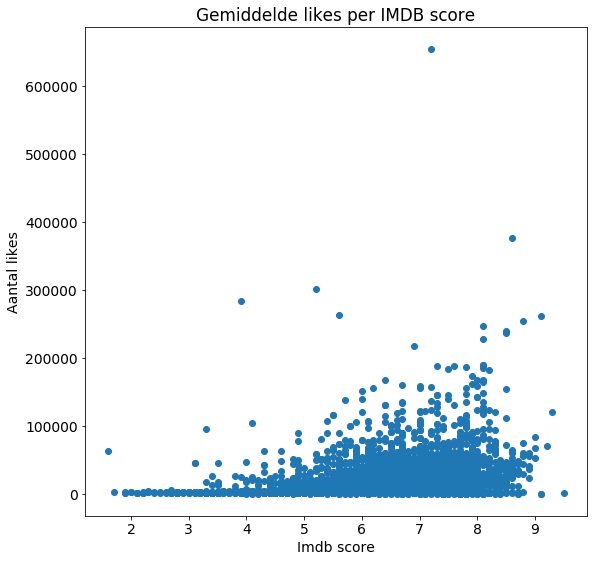

In [70]:
plt.scatter(movieData["imdb_score"], movieData["total_likes"])
plt.ylabel("Aantal likes")
plt.xlabel("Imdb score")
plt.title("Gemiddelde likes per IMDB score")
plt.show()

Zoals we in deze graph kunnen zien is dat hoe meer likes een film krijgt hoe hoger de IMDB score wordt.
Echter zien we wanneer de score boven ongeveer 9 komt de Facebook likes snel naar bededen gaan.

In [48]:
tempMovieData = movieData.sort_values(by="total_likes",ascending=False).head(n=25)
titles = tempMovieData["movie_title"]
a = tempMovieData["movie_facebook_likes"]
b = tempMovieData["actor_1_facebook_likes"]
c = tempMovieData["actor_2_facebook_likes"]
d = tempMovieData["actor_3_facebook_likes"]

In [49]:
df =  pd.DataFrame({'title' : titles,'movie likes' : a, 'actor 1 likes' : b, 'actor 2 likes' : c, 'actor 3 likes' : d})
df = df.set_index("title")

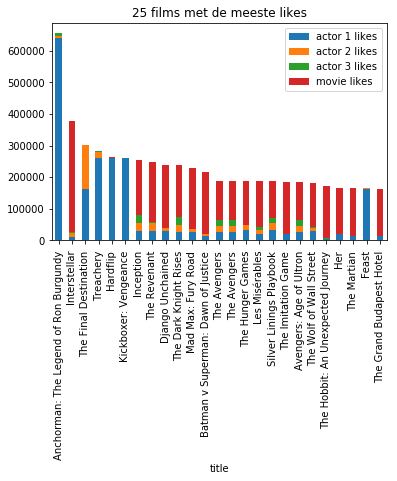

In [50]:
fig, ax = plt.subplots()

df.plot.bar(stacked=True, ax=ax);
ax.set_title("25 films met de meeste likes")
ax.legend(loc='upper right')

Hier uit kunnen we opmerken dat de films met de totaal de meeste likes meestal door de film zelf komt. Echter in de top 5 komt het bij 4 door de hoofd acteur in de film.

In [51]:
dff =  pd.DataFrame({'title' : titles,'score' : tempMovieData["imdb_score"]})
dff = dff.set_index("title")

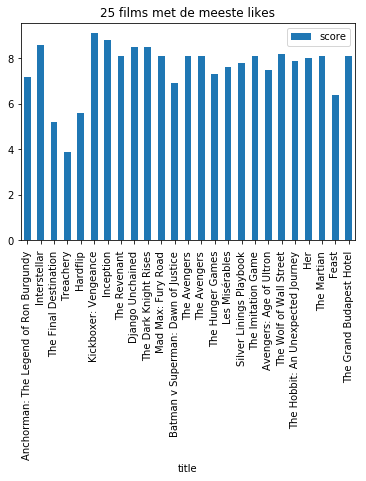

In [52]:
fig, ax = plt.subplots()

dff.plot.bar(stacked=True, ax=ax); 
ax.set_title("25 films met de meeste likes")
ax.legend(loc='upper right')

Als we vervolgens de IMDB score van deze films bekijken zien we dat ze bijna allemaal boven de de 7 zijn.
Dit is goed, maar hoe is dit in vergelijking met alle films

In [53]:
movieData["like_ratio"] =  ((movieData["total_likes"] - movieData["movie_facebook_likes"]) / movieData["total_likes"]) * 100
movieData["like_ratio"] = np.round(movieData["like_ratio"])
movieData = movieData.dropna(subset=['like_ratio'])

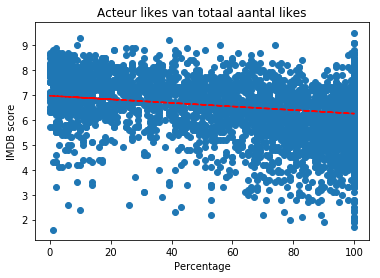

In [54]:
plt.scatter(movieData["like_ratio"], movieData["imdb_score"])
plt.ylabel("IMDB score")
plt.xlabel("Percentage")
plt.title("Acteur likes van totaal aantal likes")
z = np.polyfit(movieData["like_ratio"], movieData["imdb_score"], 1)
p = np.poly1d(z)
plt.plot(movieData["like_ratio"],p(movieData["like_ratio"]),"r--")
plt.show()

Zoals we hier kunnen zien is de aantal films per percentage redelijk stabiel. Hieruit kunnen wij concluderen dat niet direct een acteur(s) een film meer likes geeft.

## Kunnen wij met supervised machine learning voorspellen wat de IMDB score en opbrengst  van een film zijn gebaseerd op de facebook likes van de staff?

Voor we de techniek kiezen waarmee we dit gaan onderzoeken is het eerst belangrijk te weten of deze geschikt zijn. Hieronder kijken we eerst of er misschien iets van een linear verband is tussen de facebook populariteit van de cast van een film en de omzet/IMDB ervan.

In [55]:
imdbMergedArray['total_facebook_likes'] = imdbMergedArray['actor_3_facebook_likes'] + imdbMergedArray['actor_2_facebook_likes'] + imdbMergedArray['actor_1_facebook_likes']+ imdbMergedArray['director_facebook_likes']

Eerst tellen we het totaal aantal likes van de crew van de films op. Om deze data makkelijker te kunnen gebruiken

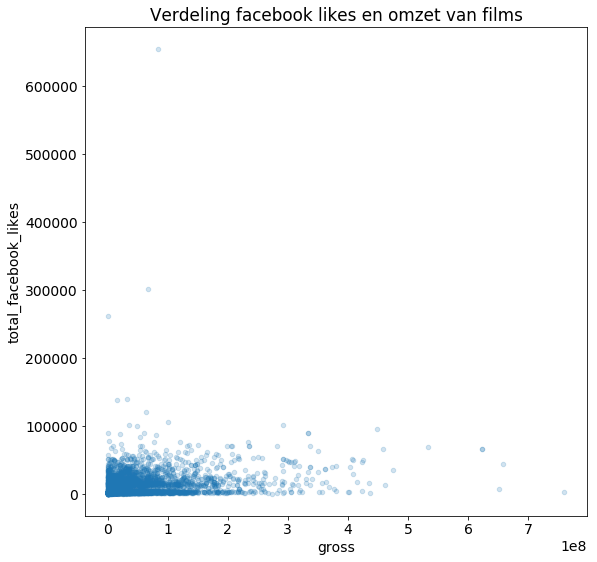

In [56]:
plt.rcParams['figure.figsize'] = (9, 9)
plt.rcParams['font.size'] = 14
imdbMergedArray.plot(kind='scatter', x= 'gross', y='total_facebook_likes', alpha=0.2,title='Verdeling facebook likes en omzet van films')

Dit blijkt niet het geval te zijn voor de omzet, nu controleren we of dit voor de IMDB score wel het geval is:

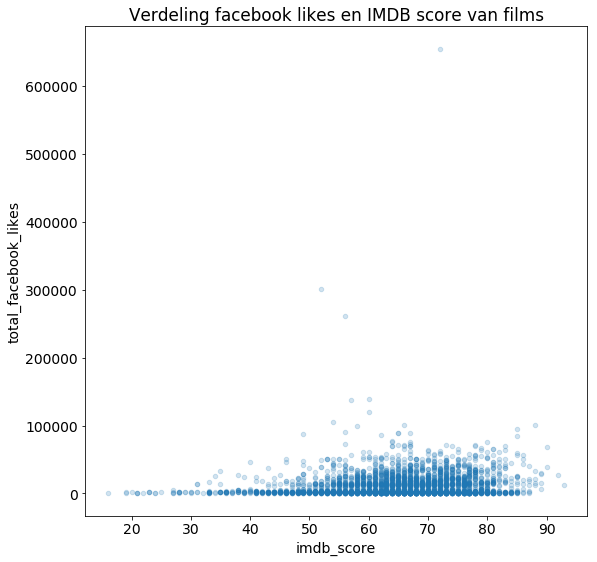

In [57]:
plt.rcParams['figure.figsize'] = (9, 9)
plt.rcParams['font.size'] = 14
imdbMergedArray.plot(kind='scatter', x= 'imdb_score', y='total_facebook_likes', alpha=0.2,title ='Verdeling facebook likes en IMDB score van films' )

Ook hiertussen is geen linear verband te vinden, omdat deze er niet is gaan we met knn klassificatie kijken of we aan de hand van de facebook likes van een film een voorspelling kunnen doen voor de omzet/IMDB score van de film. Om deze techniek toe te passen is het eerst handig om te weten of er grote uitschieters zijn die de techniek minder betrouwbaar maken.

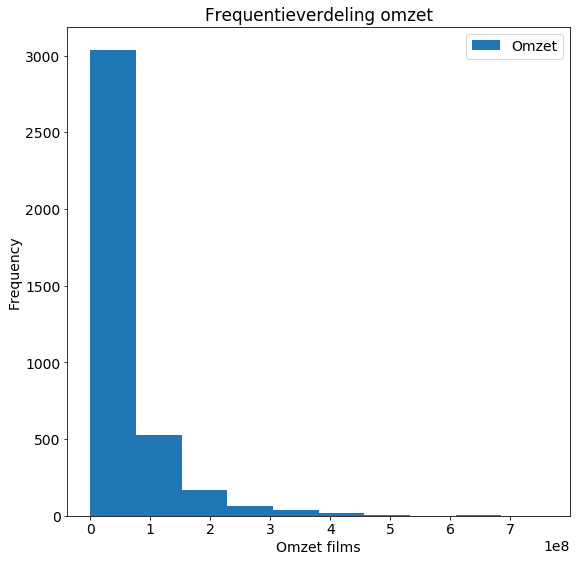

In [52]:
plt.figure();
plt.hist([imdbMergedArray['gross']],  label=['Omzet'])
plt.legend(loc='upper right')
plt.title('Frequentieverdeling omzet')
plt.xlabel('Omzet films')
plt.ylabel('Frequency')
plt.show()


Het valt op dat er wel degelijk een paar grote uitschieters zijn die de techniek minder betrouwbaar maken voor de omzet

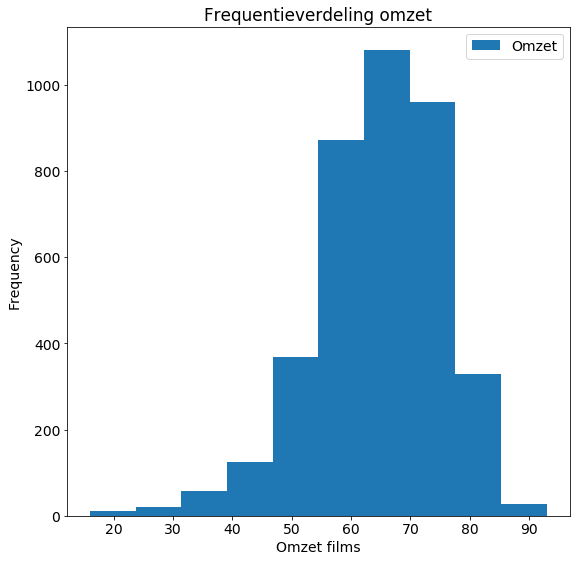

In [53]:
plt.figure();
plt.hist([imdbMergedArray['imdb_score']],  label=['Omzet'])
plt.legend(loc='upper right')
plt.title('Frequentieverdeling omzet')
plt.xlabel('Omzet films')
plt.ylabel('Frequency')
plt.show()


Ook de IMDB score heeft een aantal uitschieters, maar ziet er voor de rest redelijk normaal verdeeld uit. Nu we hier meer inzicht over hebben gaan we kijken met hoeveel zekerheid we kunnen zeggen wat een films omzet/IMDB score zal zijn aan de hand van het aantal Facebook likes. Dit gaan we doen met KNeighborsClassifier, hieronder maken we eerst een test en train set

In [54]:
X=imdbMergedArray[['total_facebook_likes']]
y= imdbMergedArray['gross']  

# making train en test set
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0)
print('Aantal trainwaarden {0:d}'.format(len(X_train)))
print('Aantal testwaarden {0:d}'.format(len(y_test)))

Aantal trainwaarden 2888
Aantal testwaarden 963


Eerst gaan kijken of we voorspellingen over de omzet kunnen doen met deze techniek.

In [55]:
# maak classifier object
knn = KNeighborsClassifier(n_neighbors = 2)
# train de classifier
knn.fit(X_train,y_train)
# laat de classifier de testset berekenen
y_knn = knn.predict(X_test)
# controleer de nauwkeurigheid met de test data
str(knn.score(X_test,y_test)*100 )+ '%'

'1.45379023884%'

Deze score is echter te laag om deze techniek in praktijk te kunnen toepassen. Wanneer je de heatmap van alle punten aan het begin terug ziet, zal je zien dat er ook weinig verband zit tussen de omzet en het aantal facebook likes. Als volgt gaan we dit voor de IMDB score ook bekijken.


In [56]:
X=imdbMergedArray[['total_facebook_likes']]
y= imdbMergedArray['imdb_score']  

# making train en test set
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0)
print('Aantal trainwaarden {0:d}'.format(len(X_train)))
print('Aantal testwaarden {0:d}'.format(len(y_test)))

Aantal trainwaarden 2888
Aantal testwaarden 963


In [57]:
# maak classifier object
knn = KNeighborsClassifier(n_neighbors = 2)
# train de classifier
knn.fit(X_train,y_train)
# laat de classifier de testset berekenen
y_knn = knn.predict(X_test)
# controleer de nauwkeurigheid met de test data
str(knn.score(X_test,y_test)*100 )+ '%'

'5.5036344756%'

Het valt op dat de voorspel score hier al een stuk hoger ligt dan bij de omzet van een film. Echter liggen beide percentages te laag om in de toekomst goede voorspellingen voor deze waardes te kunnen doen. Dit indiceert dat er weinig correlatie is tussen het aantal facebook likes van een film en de IMDB score/omzet ervan.

## Unsupervised Machine Learning

Hier willen wij graag kijken of wij met unsupervised machine learning kunnen kijken of wij met de IMDB Score en de Revenue kunnen uitvinden of de film successvol is, of onsuccessvol.

Eerst kijken wij even hoeveel meetwaarden wij hebben:

In [58]:
arraysToKeepRevenue = ['movie_title', 'imdb_score', 'gross']
imdbRevenue = imdbMergedArray[arraysToKeepRevenue]
print('Aantal meetwaarden {0:d}'.format(len(imdbRevenue)))
imdbRevenue.head()

Aantal meetwaarden 3851


,movie_title,imdb_score,gross
index,,,
0,Avatar,79.0,760505847.0
1,Pirates of the Caribbean: At World's End,71.0,309404152.0
2,Spectre,68.0,200074175.0
3,The Dark Knight Rises,85.0,448130642.0
4,John Carter,66.0,73058679.0


In [59]:
X=imdbRevenue[['imdb_score']]
y=imdbRevenue['gross']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0)
print('Aantal trainwaarden {0:d}'.format(len(X_train)))
print('Aantal testwaarden {0:d}'.format(len(y_test)))

Aantal trainwaarden 2888
Aantal testwaarden 963


### KNeighborsClassifier

In [60]:
# maak classifier object
knn = KNeighborsClassifier(n_neighbors = 2)
# train de classifier
knn.fit(X_train,y_train)
# laat de classifier de testset berekenen
y_knn = knn.predict(X_test)

acc_knn = round(accuracy_score(y_test, y_knn) * 100, 2)
print(str(acc_knn) + '%')

0.21%


### Gaussian

In [61]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_gaussian = gaussian.predict(X_test)
acc_gaussian = round(accuracy_score(y_test, y_gaussian) * 100, 2)
print(str(acc_gaussian) + '%')

0.1%


Even een kort model om te zien hoe accuraat de predicties zijn:

In [62]:
models = pd.DataFrame({
    'Model': [ 'KNN', 'Gaussian Naive Baise'],
    'Score': [ acc_knn, acc_gaussian]})

models.sort_values(by='Score', ascending=False)

,Model,Score
0,KNN,0.21
1,Gaussian Naive Baise,0.10


Hieraan kunnen wij al snel zien dat er een zeer lage correlatie is tussen IMDB Score en gross revenue, dit betekent dat een film niet goed hoeft te zijn om veel te verdienen. Of dat een film zeer weinig kan verdienen terwijl het een zeer hoge IMDB Score heeft.

Dit klopt met wat het eerdere analyse vertelde, wij kunnen dus waarschijnlijk zeggen dat Facebook likes en IMDB Scores niet veel vertellen over hoeveel de film verdient.